In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle
import os

import dask.dataframe as dd
import folium 
import datetime
import time
import matplotlib
matplotlib.use('nbagg')
from matplotlib import rcParams

import gpxpy.geo
from sklearn.cluster import MiniBatchKMeans, KMeans
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression


In [2]:
dd_frame = dd.read_csv('yellow_tripdata_2015-01.csv')

In [3]:
dd_frame.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

## Data Visualization & Cleaning

- <h4>Newyork is bounded by the location coordinates (lat,long) - (40.5774, -74.15) & (40.9176,-73.7004). </h4>
- <h4>  So any pickups and drop-offs outiside this range will be outliers</h4>

#### 1. Plotting Pickup Outliers

In [4]:
outlier_locations_pickups = dd_frame[((dd_frame.pickup_longitude <= -74.15) | (dd_frame.pickup_latitude <= 40.5774)| \
                   (dd_frame.pickup_longitude >= -73.7004) | (dd_frame.pickup_latitude >= 40.9176))]

In [5]:
#http://folium.readthedocs.io/en/latest/quickstart.html
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# spotting first 100 outliers on the map in order to visualize
sample_locations = outlier_locations_pickups.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

- We can see outliers mostly outside newyork,some located  in even in ocean and others in south american countries belize and columbia

#### 2. Plotting drop-off Outliers

In [6]:
outlier_locations_dropoff = dd_frame[((dd_frame.dropoff_longitude <= -74.15) | (dd_frame.dropoff_latitude <= 40.5774)| \
                   (dd_frame.dropoff_longitude >= -73.7004) | (dd_frame.dropoff_latitude >= 40.9176))]

In [7]:
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations_dropoff.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

- Here too we can observe outliers outside newyork and some even in Europe and in Ocean

#### 3. Trip Duration

In [8]:
dd_frame['tpep_dropoff_datetime'].head()

0    2015-01-15 19:23:42
1    2015-01-10 20:53:28
2    2015-01-10 20:43:41
3    2015-01-10 20:35:31
4    2015-01-10 20:52:58
Name: tpep_dropoff_datetime, dtype: object

In [9]:
# Coverting unix time stamp to date time
# https://stackoverflow.com/a/27914405
def unix_to_date(d):
    return time.mktime(datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S').timetuple())

In [10]:
def creating_trip_time(dd_frame):
    # loading all the values from pickup and drop off cols of original dataframe
    pickup_dropoff = dd_frame[['tpep_pickup_datetime', 'tpep_dropoff_datetime']].compute()
    
    # Converting Unix to time
    duration_pickup = [unix_to_date(x) for x in pickup_dropoff['tpep_pickup_datetime'].values]
    duration_drop = [unix_to_date(x) for x in pickup_dropoff['tpep_dropoff_datetime'].values]
    
    # calculating trip Duration
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)
    
    # Making a new dataframe with required features
    new_frame = dd_frame[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    # adding new attributes to the new dataframe
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['speed'] = 60* (new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

    
new_frame = creating_trip_time(dd_frame)

##### EDA: Trip Times

<IPython.core.display.Javascript object>


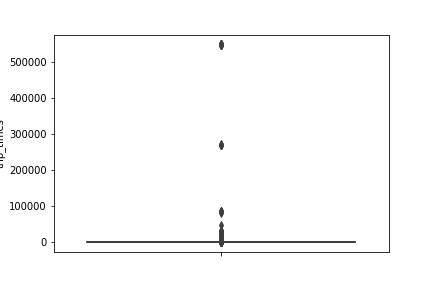

In [11]:
sns.boxplot(y = 'trip_times' , data = new_frame)
plt.show()

In [12]:
for i in range(0,100,10):
    vals = new_frame['trip_times'].values
    vals = np.sort(vals, axis = None)
    print("{} percentile value is {}".format(i,vals[int(len(vals)*(float(i)/100))]))
print ("100 percentile value is ",vals[-1])

0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45
100 percentile value is  548555.6333333333


In [13]:
i = [i/100 for i in range(90,100)]
new_frame['trip_times'].quantile(i)

0.90    23.450000
0.91    24.350000
0.92    25.383333
0.93    26.550000
0.94    27.933333
0.95    29.583333
0.96    31.683333
0.97    34.466667
0.98    38.716667
0.99    46.750000
Name: trip_times, dtype: float64

- According to TLC regulations in newyork trip time in a day shouldn't be more than 12 hrs

In [14]:
# Removing data points which are outliers based on our observations and TLC regulations
new_frame_modified=new_frame[(new_frame.trip_times>1) & (new_frame.trip_times<720)]

In [15]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =new_frame_modified)
plt.show()

<IPython.core.display.Javascript object>


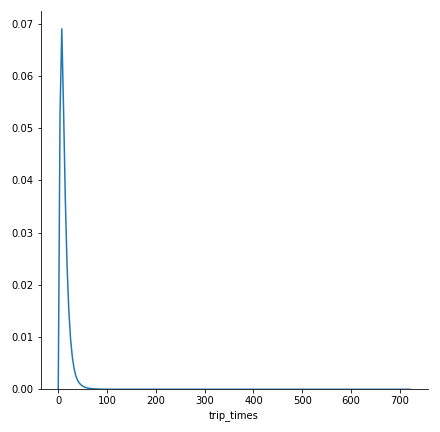

In [16]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(new_frame_modified,size=6) \
      .map(sns.kdeplot,"trip_times").add_legend()
plt.show()

In [17]:
#converting the values to log-values to chec for log-normal
new_frame_modified['log_times']=[math.log(i) for i in new_frame_modified['trip_times'].values]

<IPython.core.display.Javascript object>


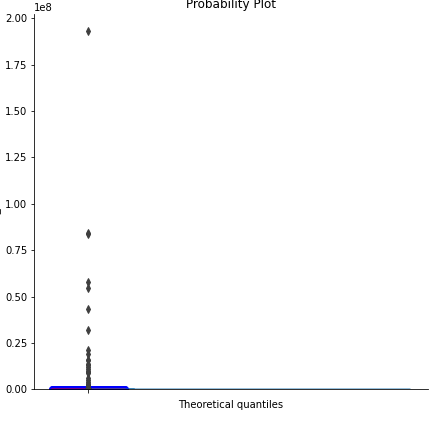

In [18]:
#pdf of log-values
sns.FacetGrid(new_frame_modified,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt.show();

In [19]:
import scipy

In [20]:
#Q-Q plot for checking if trip-times is log-normal
scipy.stats.probplot(new_frame_modified['log_times'].values, plot=plt)
plt.show()

#### EDA : Speed

In [21]:
new_frame_modified['Speed'] = 60*(new_frame_modified['trip_distance']/new_frame_modified['trip_times'])
sns.boxplot(y="Speed", data = new_frame_modified)
plt.show()

In [22]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
i = [ i/100 for i in range(0,110,10)]
new_frame_modified['Speed'].quantile(i)

0.0    0.000000e+00
0.1    6.409496e+00
0.2    7.809524e+00
0.3    8.929134e+00
0.4    9.980198e+00
0.5    1.106866e+01
0.6    1.228669e+01
0.7    1.379641e+01
0.8    1.596322e+01
0.9    2.018692e+01
1.0    1.928571e+08
Name: Speed, dtype: float64

In [23]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
i = [i/100 for i in range(90,101)]
new_frame_modified['Speed'].quantile(i)

0.90    2.018692e+01
0.91    2.091645e+01
0.92    2.175299e+01
0.93    2.272189e+01
0.94    2.384416e+01
0.95    2.518255e+01
0.96    2.680851e+01
0.97    2.884305e+01
0.98    3.159113e+01
0.99    3.575135e+01
1.00    1.928571e+08
Name: Speed, dtype: float64

In [24]:
i = [ (i+ 99)/100 for i in np.arange(0.0, 1.0, 0.1)]
new_frame_modified['Speed'].quantile(i)

0.990    35.751351
0.991    36.310813
0.992    36.914701
0.993    37.588235
0.994    38.330334
0.995    39.175800
0.996    40.153846
0.997    41.338029
0.998    42.866244
0.999    45.310675
Name: Speed, dtype: float64

In [25]:
#removing further outliers based on the 99.9th percentile value
new_frame_modified=new_frame[(new_frame.speed>0) & (new_frame.speed<45.31)]

In [26]:
sum(new_frame_modified["speed"]) / float(len(new_frame_modified["speed"]))

12.450173996027528

<b style='font-size:16px'>The avg speed in Newyork speed is 12.45miles/hr, so a cab driver can travel <font color='blue'> 2 miles per 10min on avg.</font> </b>

In [27]:
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data = new_frame_modified)
plt.show()

In [28]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
i = [ i/100 for i in range(0,110,10)]
new_frame_modified['trip_distance'].quantile(i)

0.0      0.01
0.1      0.66
0.2      0.90
0.3      1.10
0.4      1.39
0.5      1.69
0.6      2.07
0.7      2.60
0.8      3.60
0.9      5.97
1.0    258.90
Name: trip_distance, dtype: float64

In [29]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
i = [i/100 for i in range(90,101)]
new_frame_modified['trip_distance'].quantile(i)

0.90      5.97
0.91      6.45
0.92      7.07
0.93      7.85
0.94      8.72
0.95      9.60
0.96     10.60
0.97     12.10
0.98     16.03
0.99     18.17
1.00    258.90
Name: trip_distance, dtype: float64

In [30]:
i = [ (i+ 99)/100 for i in np.arange(0.0, 1.1, 0.1)]
new_frame_modified['trip_distance'].quantile(i)

0.990     18.17
0.991     18.37
0.992     18.60
0.993     18.83
0.994     19.13
0.995     19.50
0.996     19.96
0.997     20.50
0.998     21.22
0.999     22.57
1.000    258.90
Name: trip_distance, dtype: float64

In [31]:
new_frame_modified=new_frame[(new_frame.trip_distance>0) & (new_frame.trip_distance<23)]

In [32]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = new_frame_modified)
plt.show()

#### EDA: Total Fare

In [33]:
# checking for any outliers in the data based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data = new_frame_modified)
plt.show()

In [34]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
i = [ i/100 for i in range(0,110,10)]
new_frame_modified['total_amount'].quantile(i)

0.0       -242.55
0.1          6.30
0.2          7.80
0.3          8.80
0.4          9.80
0.5         11.16
0.6         12.80
0.7         14.80
0.8         18.30
0.9         25.80
1.0    3950611.60
Name: total_amount, dtype: float64

In [35]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
i = [i/100 for i in range(90,101)]
new_frame_modified['total_amount'].quantile(i)

0.90         25.80
0.91         27.30
0.92         29.30
0.93         31.80
0.94         34.80
0.95         38.53
0.96         42.60
0.97         48.13
0.98         58.13
0.99         66.13
1.00    3950611.60
Name: total_amount, dtype: float64

In [36]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = new_frame_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 66.13
99.1 percentile value is 68.13
99.2 percentile value is 69.6
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.75
99.6 percentile value is 69.76
99.7 percentile value is 72.58
99.8 percentile value is 75.35
99.9 percentile value is 88.28
100 percentile value is  3950611.6


In [37]:
# Looking closely at last 50 values excluding last 2 values 
plt.plot(var[-50: -2])
plt.show()

### Remove all outliers/erronous points.

In [38]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))
    
    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.speed <= 65) & (new_frame.speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.speed < 45.31) & (new_frame.speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [39]:
print ("Removing outliers in the month of Jan-2015")
print ("----")
new_frame_modified = remove_outliers(new_frame)
print("fraction of data points that remain after removing outliers", float(len(new_frame_modified))/len(new_frame))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 24473
Number of outliers from fare analysis: 5275
Total outliers removed 377910
---
fraction of data points that remain after removing outliers 0.9703576425607495


## Data-Preperation
### Clustering/Segmentation

In [40]:
coords = new_frame_modified[['pickup_latitude', 'pickup_longitude']].values
neighbours = []

In [41]:
coords = new_frame_modified[['pickup_latitude', 'pickup_longitude']].values
neighbours = []
def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist = 1000
    for i in range (0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!= i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0],cluster_centers[i][1],cluster_centers[j][0],cluster_centers[j][1])
                min_dist = min(min_dist, distance/(1.60934 * 1000))
                if (distance/(1.60934 * 1000)) <= 2:
                    nice_points += 1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n======================")
    
def find_clusters(increments):
    kmeans = MiniBatchKMeans(n_clusters = increments, batch_size = 10000, random_state = 42).fit(coords)
    new_frame_modified['pickup_cluster'] =  kmeans.predict(new_frame_modified[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for i in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(i)
    find_min_distance(cluster_centers, cluster_len)            

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  1.0945442325142662 
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 4.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 16.0 
Min inter-cluster distance =  0.7131298007388065 
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 22.0 
Min inter-cluster distance =  0.5185088176172186 
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 32.0 
Min inter-cluster distance =  0.5069768

### Inferences :
- We have observed that with avg speed a cab can travel 2 miles in 10 mins. If inter cluster distance in more than 2 miles it will tkae more than 10 mins to reach another cluster. 
- we want the majority of the clusters with in 2 miles of distance not less than 0.5 mile else they will be too close.
- So we will chose number of clusters to be 40 which satisfies our requirement well.

In [42]:
# Retraining kmeans with 40 clusters
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0).fit(coords)
new_frame_modified['pickup_cluster'] = kmeans.predict(new_frame_modified[['pickup_latitude', 'pickup_longitude']])

## Plotting cluster centers:

In [43]:
# plotting the cluster centers 
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
     folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

## Plotting the clusters:


<IPython.core.display.Javascript object>


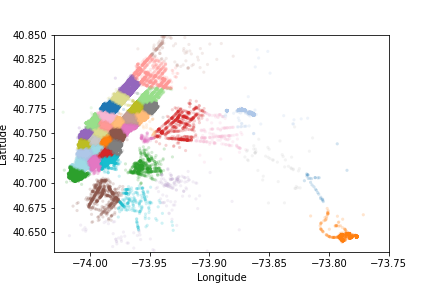

In [44]:
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols = 1, nrows = 1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s = 10, lw = 0,
              c = frame.pickup_cluster.values[:100000], cmap = 'tab20', alpha = 0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(new_frame_modified)

In [45]:
#Refer:https://www.unixtimestamp.com/
def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [46]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
# we add two more columns 'pickup_cluster'(to which cluster it belogns to) 
# and 'pickup_bins' (to which 10min intravel the trip belongs to)

new_frame_modified['pickup_cluster'] = kmeans.predict(new_frame_modified[['pickup_latitude', 'pickup_longitude']])
jan_2015_frame = add_pickup_bins(new_frame_modified,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [47]:
jan_2015_frame.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      speed  pickup_cluster  pickup_bins  
0  1.421329e+09   5.285319              34         2130  
1  1.420902e+09   9.983193               2         1419  
2  1.420902e+09  10.746269              16         1419  
3  1.420902e+09  16.071429              38         1419  
4  1.420902e+09   9.318378              22         1419

In [48]:
# hear the trip_distance represents the number of pickups that are happend in that particular 10min intravel
# this data frame has two indices
# primary index: pickup_cluster (cluster number)
# secondary index : pickup_bins (we devid whole months time into 10min intravels 24*31*60/10 =4464bins)
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              1                      105
               2                      199
               3                      208
               4                      141
               5                      155

#### Upto now we cleaned and prepared data for the month 2015,now  will do the same operations for months of Jan, Feb, March for year 2016
- 1. get the dataframe which inlcudes only required colums
- 2. adding trip times, speed, unix time stamp of pickup_time
- 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
- 5. add pickup_cluster to each data point
- 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
- 7. group by data, based on 'pickup_cluster' and 'pickuo_bin'

In [49]:
# Data Preparation for the months of Jan,Feb and March 2016

def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = creating_trip_time(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
month_jan_2016 = dd.read_csv('yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv')

jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)
feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)
mar_2016_frame,mar_2016_groupby = datapreparation(month_mar_2016,kmeans,3,2016)

Return with trip times..
Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  11382049
Number of outlier coordinates lying outside NY boundaries: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 22437
Number of outliers from fare analysis: 5476
Total outliers removed 308177
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  12210952
Number of outlier coordinates lying outside NY boundaries: 232444
Number of outliers fro

###  Smoothing

In [50]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# we got an observation that there are some pickpbins that doesnt have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [51]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

#jan
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

#feb
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

#march
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [52]:
# for each cluster number of 10min intravels with 0 pickups
for i in range(40):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2015_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  41
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  1986
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  30
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  355
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  38
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  154
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  35
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  34
---------

In [53]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [54]:
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,40):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [55]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

#Smoothing Missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)

In [56]:
print("number of 10min intravels among all the clusters ",len(jan_2015_fill))

number of 10min intravels among all the clusters  178560


<IPython.core.display.Javascript object>


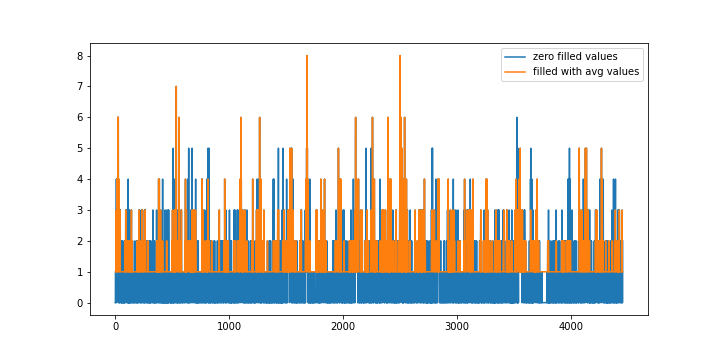

In [57]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_2015_fill[4464:8920], label="zero filled values")
plt.plot(jan_2015_smooth[4464:8920], label="filled with avg values")
plt.legend()
plt.show()

In [58]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)

- number of 10min indices for jan 2015= 24*31*60/10 = 4464
- number of 10min indices for jan 2016 = 24*31*60/10 = 4464
- number of 10min indices for feb 2016 = 24*29*60/10 = 4176
- number of 10min indices for march 2016 = 24*31*60/10 = 4464
- regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups that are happened for three months in 2016 data


In [59]:
regions_cum = []

for i in range(0,40):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])

print(len(regions_cum))
print(len(regions_cum[0]))

40
13104


## Time series and Fourier Transforms

<IPython.core.display.Javascript object>


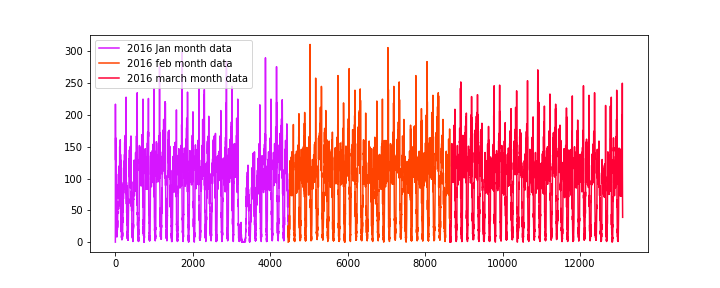

<IPython.core.display.Javascript object>


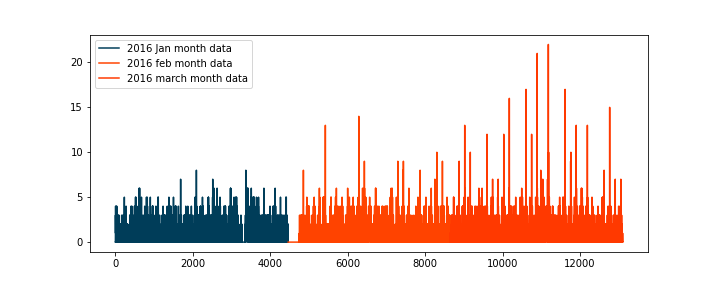

<IPython.core.display.Javascript object>


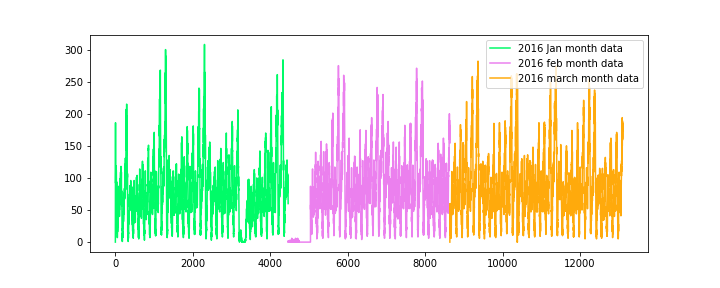

<IPython.core.display.Javascript object>


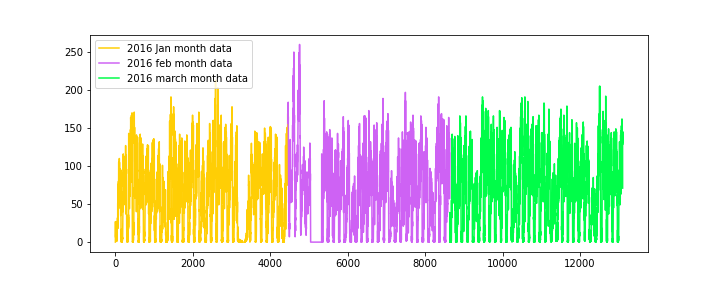

<IPython.core.display.Javascript object>


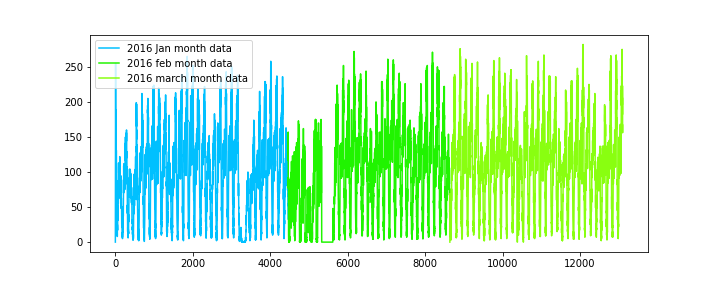

<IPython.core.display.Javascript object>


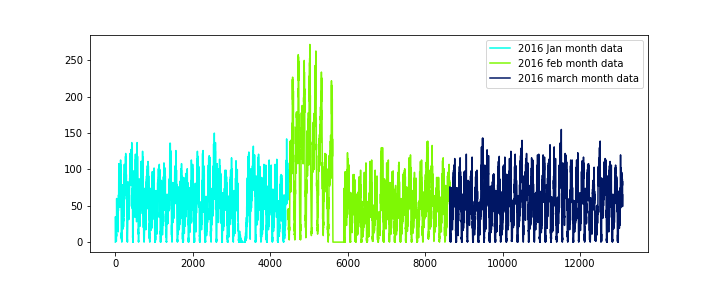

<IPython.core.display.Javascript object>


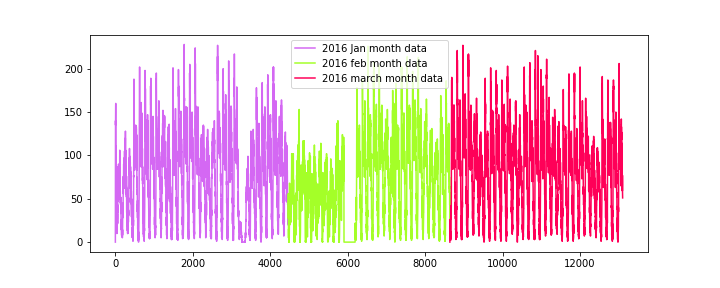

<IPython.core.display.Javascript object>


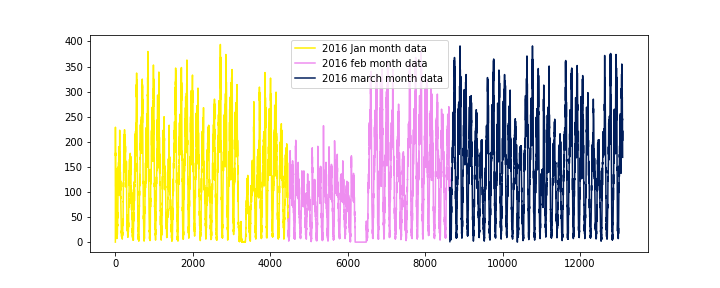

<IPython.core.display.Javascript object>


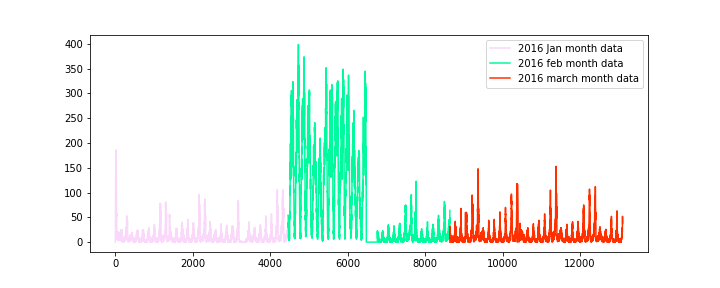

<IPython.core.display.Javascript object>


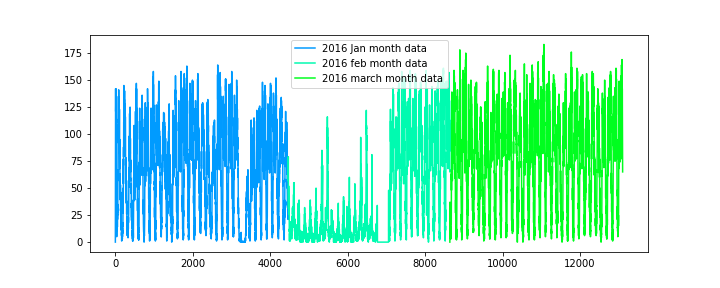

<IPython.core.display.Javascript object>


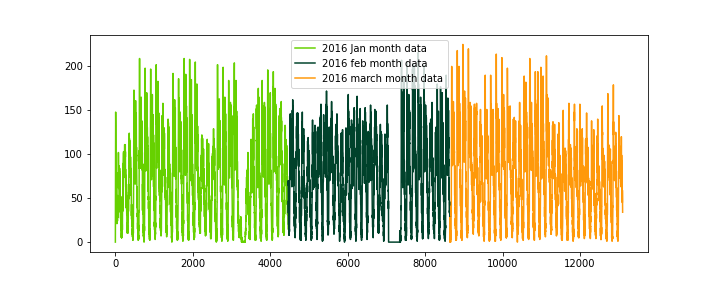

<IPython.core.display.Javascript object>


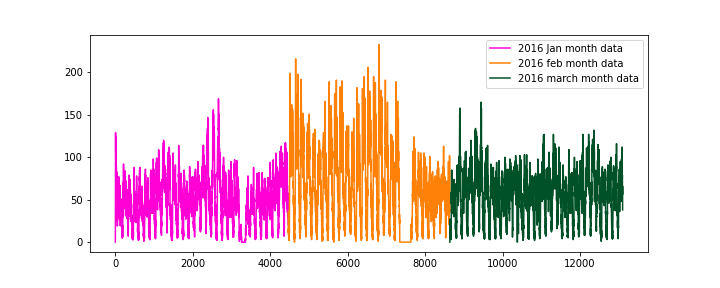

<IPython.core.display.Javascript object>


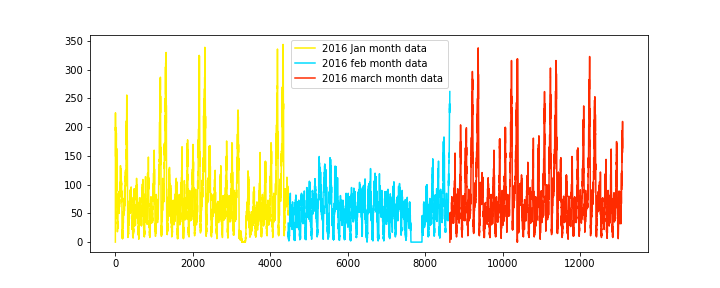

<IPython.core.display.Javascript object>


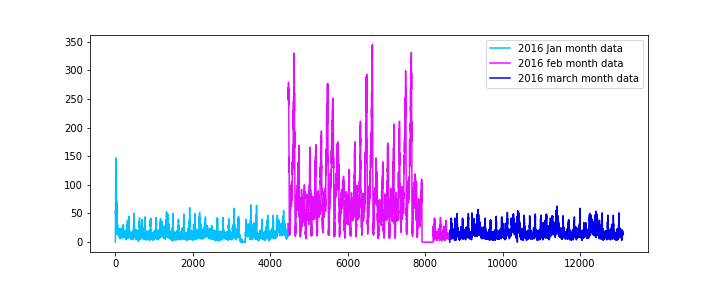

<IPython.core.display.Javascript object>


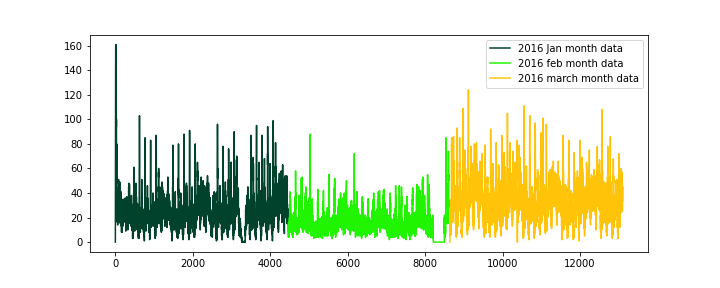

<IPython.core.display.Javascript object>


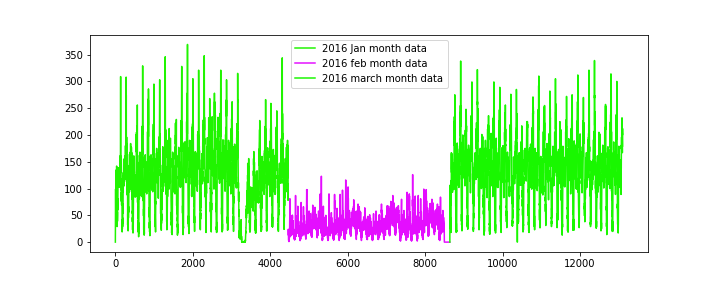

<IPython.core.display.Javascript object>


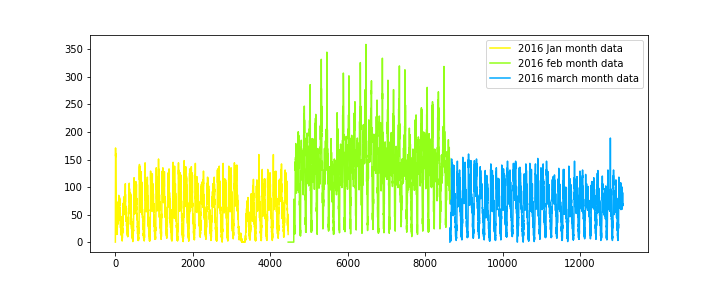

<IPython.core.display.Javascript object>


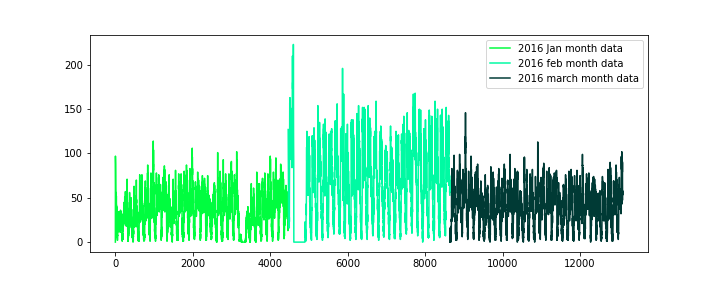

<IPython.core.display.Javascript object>


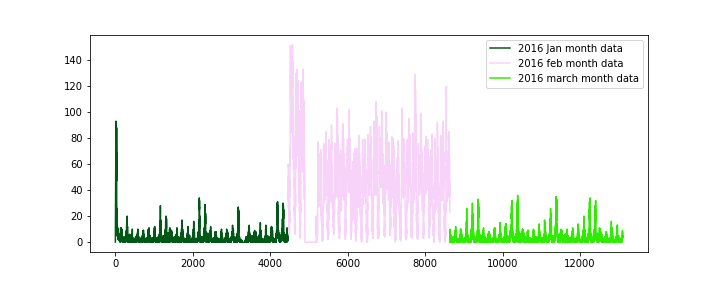

<IPython.core.display.Javascript object>


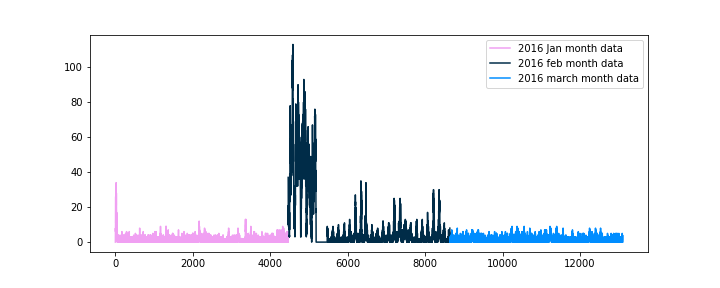

<IPython.core.display.Javascript object>


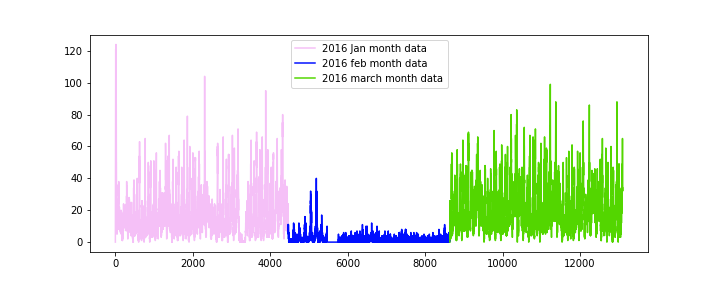

<IPython.core.display.Javascript object>


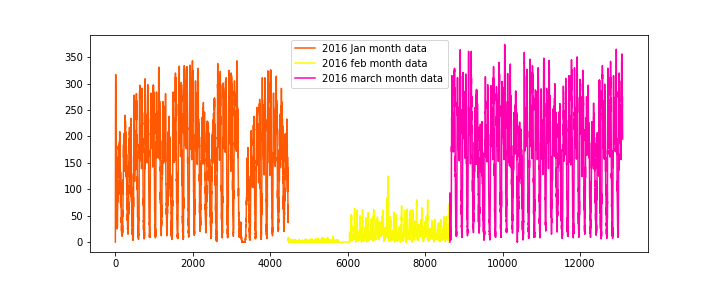

<IPython.core.display.Javascript object>


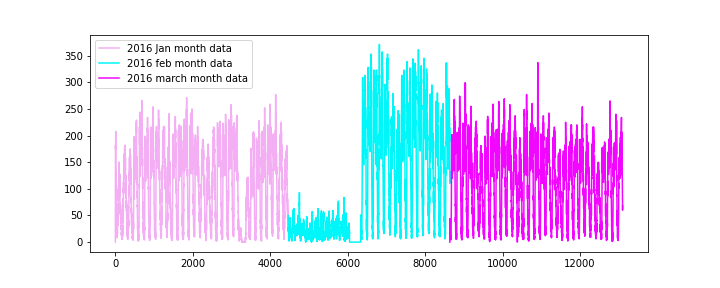

<IPython.core.display.Javascript object>


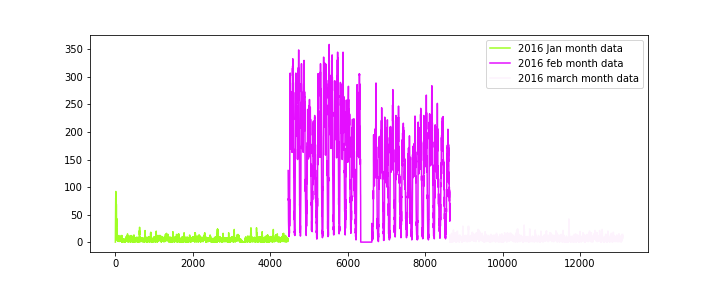

<IPython.core.display.Javascript object>


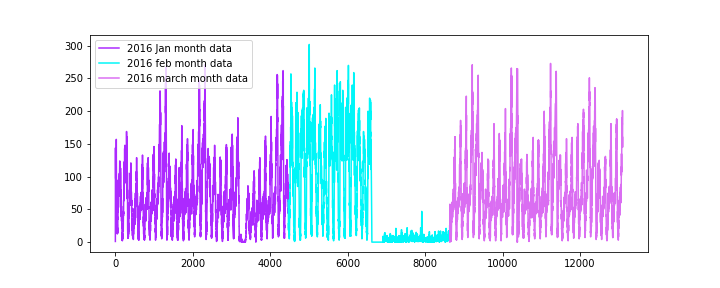

<IPython.core.display.Javascript object>


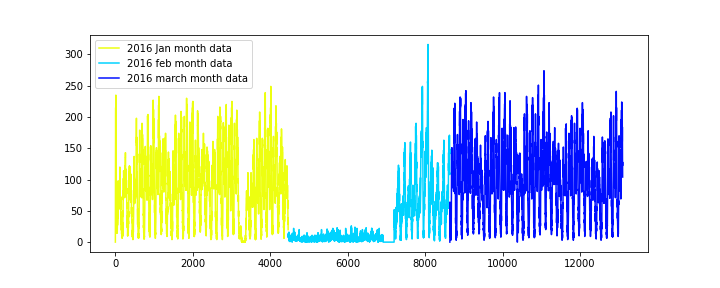

<IPython.core.display.Javascript object>


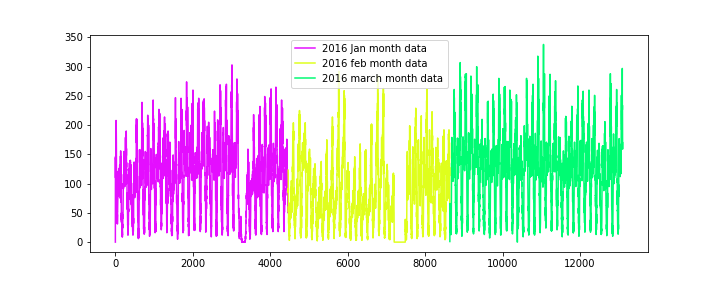

<IPython.core.display.Javascript object>


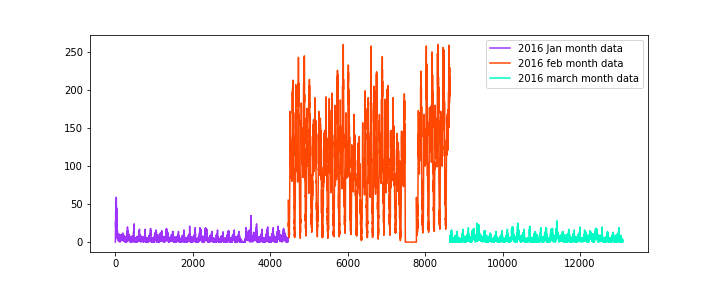

<IPython.core.display.Javascript object>


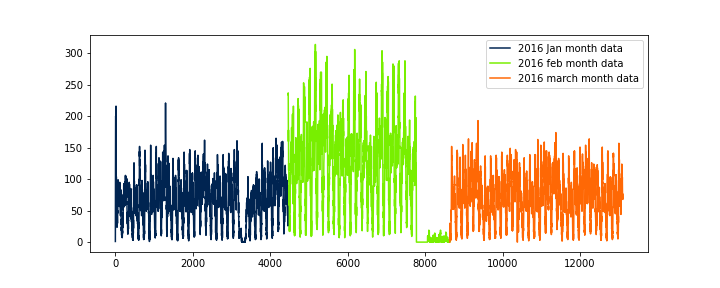

<IPython.core.display.Javascript object>


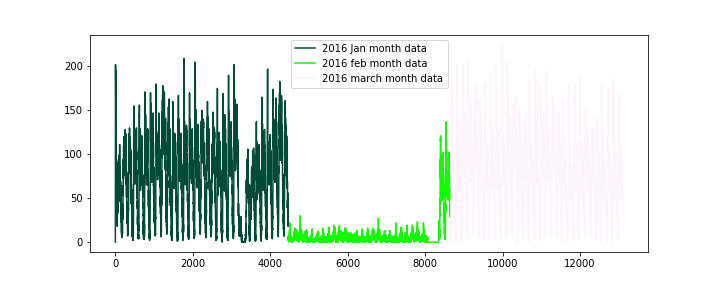

<IPython.core.display.Javascript object>


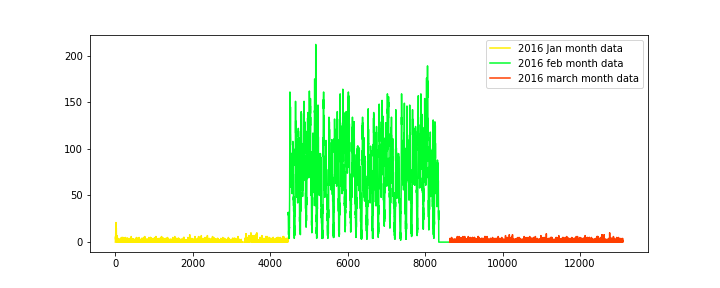

<IPython.core.display.Javascript object>


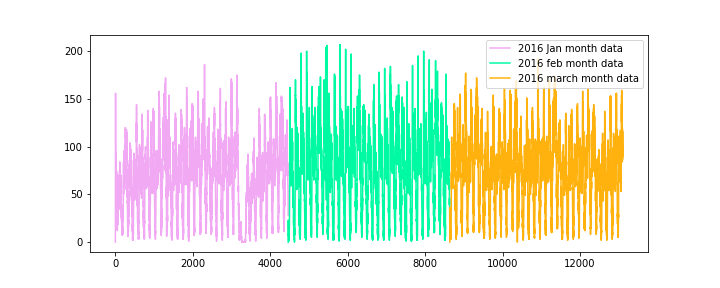

<IPython.core.display.Javascript object>


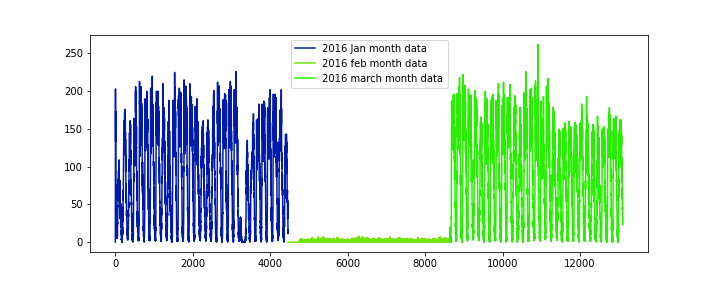

<IPython.core.display.Javascript object>


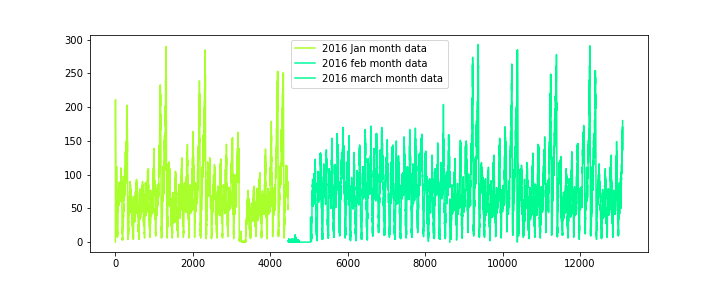

<IPython.core.display.Javascript object>


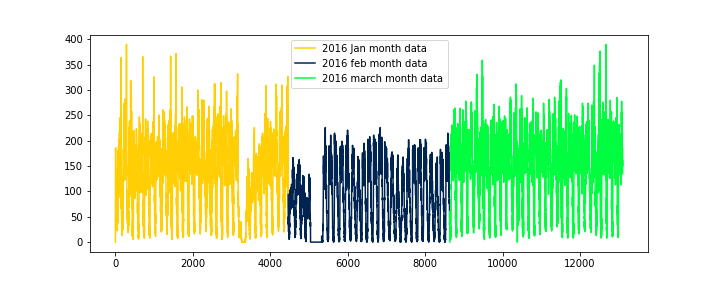

<IPython.core.display.Javascript object>


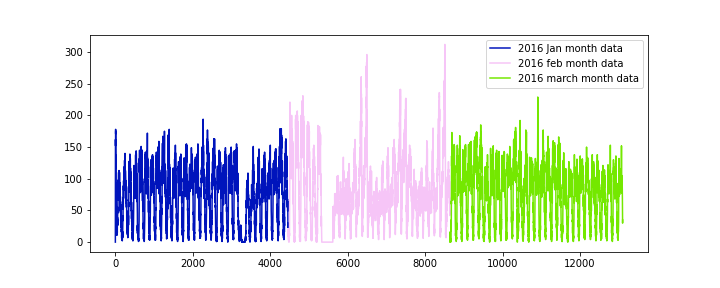

<IPython.core.display.Javascript object>


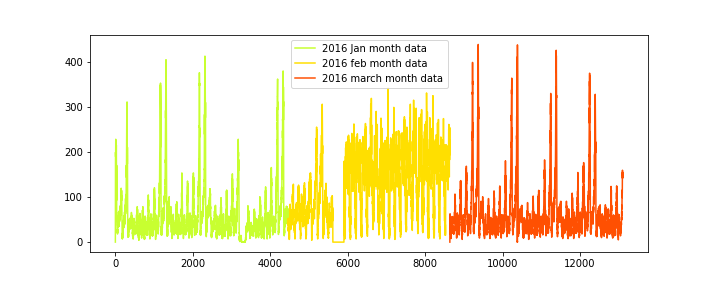

<IPython.core.display.Javascript object>


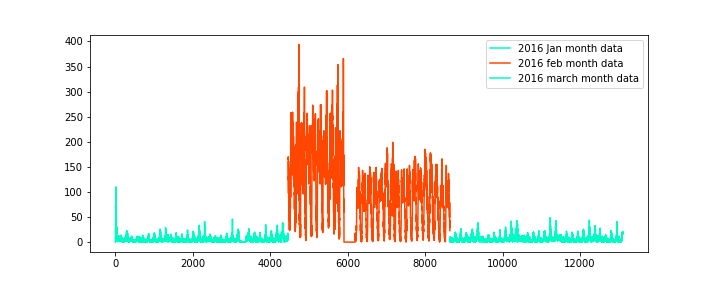

<IPython.core.display.Javascript object>


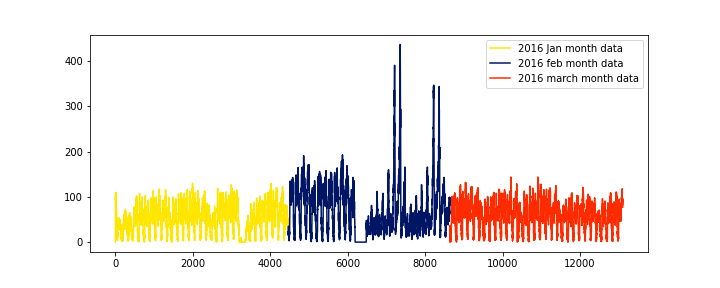

<IPython.core.display.Javascript object>


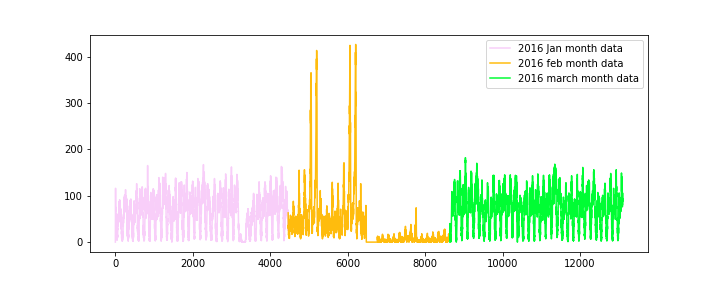

In [60]:
def uniqueish_color():
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
second_x = list(range(4464,8640))
third_x = list(range(8640,13104))
for i in range(40):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_cum[i][:4464], color=uniqueish_color(), label='2016 Jan month data')
    plt.plot(second_x,regions_cum[i][4464:8640], color=uniqueish_color(), label='2016 feb month data')
    plt.plot(third_x,regions_cum[i][8640:], color=uniqueish_color(), label='2016 march month data')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


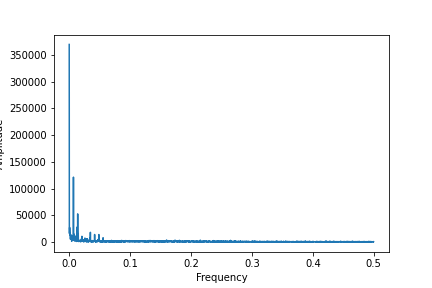

In [61]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
Y = np.fft.fft(np.array(jan_2016_smooth[0:4460]))
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [62]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2015_smooth
ratios_jan['Prediction']=jan_2016_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

### Simple Moving Averages
Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$

In [63]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [64]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [65]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [66]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

### Exponential  Weighted Moving Averages

In [67]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [68]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [69]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

In [71]:
print ("Error Metric Summary(Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Summary(Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.1821155173392136       MSE:  400.0625504032258
Moving Averages (2016 Values) -                        MAPE:  0.14292849686975506        MSE:  174.84901993727598
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.1784869254376018       MSE:  384.01578741039424
Weighted Moving Averages (2016 Values) -               MAPE:  0.13551088436182082       MSE:  162.46707549283155
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.17783550194861494       MSE:  378.34610215053766
Exponential Moving Averages (2016 Values) -         MAPE:  0.135091526

> From the above table we can observe that the best forecasting model for our prediction is Exponential Moving Averages
> So we will use this as a feature in building our model.

## Training ML Model

In [74]:
# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

# we take number of pickups that are happened in last 5 10min intravels as 5 features in our input
number_of_time_stamps = 5

# output varaible is a list of lists and it will contain 13099 pickups for each cluster
output = []


# cluster_lat  and cluster_lon will contain 13104-5=13099 times lattitudes and longitudes of cluster center for every cluster
# Ex: [[cent_lat 13099times],[cent_lat 13099times], [cent_lat 13099times].... 40 lists].Both are list of lists

cluster_lat = []
cluster_lon = []

# we will code each day with sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
weekday = []

feature = []


feature = [0]*number_of_time_stamps
for i in range(0,40):
    cluster_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    cluster_lon.append([kmeans.cluster_centers_[i][1]]*13099)
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
        
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    feature = np.vstack((feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
feature = feature[1:]

In [75]:
len(cluster_lat[0])*len(cluster_lat) == feature.shape[0] == len(weekday)*len(weekday[0]) == 40*13099 == len(output)*len(output[0])

True

In [76]:
# Exp moving avrg p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3
predicted_values=[]

predict_list = []
for r in range(0,40):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

 We have the following 9 features as input to train our model. 
 1. cluster center lattitude
 2. cluster center longitude
 3. day of the week 
 4. f_t1: number of pickups that are happened previous t-1th 10min intravel
 5. f_t2: number of pickups that are happened previous t-2th 10min intravel
 6. f_t3: number of pickups that are happened previous t-3th 10min intravel
 7. f_t4: number of pickups that are happened previous t-4th 10min intravel
 8. f_t5: number of pickups that are happened previous t-5th 10min intravel
 9. Exponential Moving avrg

### Train Test Split

In [77]:
train=  [feature[i*13099:(13099*i+9169)] for i in range(0,40)]
test= [feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]

In [80]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_flat_lat = [i[:9169] for i in cluster_lat]
train_flat_lon = [i[:9169] for i in cluster_lon]
train_flat_weekday = [i[:9169] for i in weekday]
train_flat_output = [i[:9169] for i in output]
train_flat_exp_avg = [i[:9169] for i in predict_list]

In [81]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
test_flat_lat = [i[9169:] for i in cluster_lat]
test_flat_lon = [i[9169:] for i in cluster_lon]
test_flat_weekday = [i[9169:] for i in weekday]
test_flat_output = [i[9169:] for i in output]
test_flat_exp_avg = [i[9169:] for i in predict_list]

In [82]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,40):
    train_new_features.extend(train[i])
test_new_features = []
for i in range(0,40):
    test_new_features.extend(test[i])

In [83]:
train_lat = sum(train_flat_lat, [])
train_lon = sum(train_flat_lon, [])
train_weekday = sum(train_flat_weekday, [])
train_output = sum(train_flat_output, [])
train_exp_avg = sum(train_flat_exp_avg,[])

In [84]:
# Preparing the data frame for our train data

test_lat = sum(test_flat_lat, [])
test_lon = sum(test_flat_lon, [])
test_weekday = sum(test_flat_weekday, [])
test_output = sum(test_flat_output, [])
test_exp_avg = sum(test_flat_exp_avg,[])

In [85]:
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = train_lat
df_train['lon'] = train_lon
df_train['weekday'] = train_weekday
df_train['exp_avg'] = train_exp_avg

print(df_train.shape)

(366760, 9)


In [86]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = test_lat
df_test['lon'] = test_lon
df_test['weekday'] = test_weekday
df_test['exp_avg'] = test_exp_avg
print(df_test.shape)

(157200, 9)


## Training Models

### Using Linear Regression

In [88]:
lr_reg=LinearRegression().fit(df_train, train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

### Using RF Regressor

In [91]:
regr_rf = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr_rf.fit(df_train, train_output)


y_pred_2 = regr_rf.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred_2]
y_pred_2 = regr_rf.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred_2]

In [94]:

train_rf  = ((mean_absolute_error(train_output,rndf_train_predictions))/(sum(train_output)/len(train_output)))
train_lr = ((mean_absolute_error(train_output, lr_train_predictions))/(sum(train_output)/len(train_output)))

test_rf = ((mean_absolute_error(test_output, rndf_test_predictions))/(sum(test_output)/len(test_output)))
test_lr = ((mean_absolute_error(test_output, lr_test_predictions))/(sum(test_output)/len(test_output)))

In [95]:
print ("Linear Regression -                         Train: ",train_lr,"      Test: ",test_lr)
print ("Random Forest Regression -                   Train: ",train_rf,"     Test: ",test_rf)

Linear Regression -                         Train:  0.13331572016045437       Test:  0.1291202994009687
Random Forest Regression -                   Train:  0.09177881054570687      Test:  0.1271213621367871


### Summary
- Using only exponetial moving average we got MAPE of 0.1305
- Using the ML Models we didnt get much significant reduction in MAPE value
- Random Forest Regressor id overfitting the data 
- Simple Linear Regression seems to be very powerful and fits the data properly